# Project 01: Eigen-Forge - Computational Linear Algebra from Scratch

**Author:** Davi Bonetto  
**Course Module:** 01-Janeiro-Math

## 1. Introduction

In the realm of modern Artificial Intelligence, the matrix is the fundamental data structure. From the simple weights of a logistic regression model to the billions of parameters in Large Language Models (LLMs), nearly every operation boils down to linear algebra. Frameworks like PyTorch and TensorFlow abstract these operations with highly optimized C++ and CUDA kernels (BLAS/LAPACK).

However, to truly master the "Ghost in the Machine," one must understand how these engines are forged.

**Objective:**
This project implements a **Matrix Engine** using **Pure Python** (no helper libraries for core logic). We will demonstrate an algorithmic understanding of:
1.  **Matrix Multiplication** ($O(n^3)$)
2.  **Eigenvalue Decomposition** (via Power Iteration)
3.  **Singular Value Decomposition (SVD)** (Conceptual & Visual Application)

---

## 2. Theoretical Foundations

### 2.1 Matrix Multiplication
The product of two matrices $A$ (shape $m \times n$) and $B$ (shape $n \times p$) results in a matrix $C$ (shape $m \times p$). The element at row $i$ and column $j$ is defined as the dot product of the $i$-th row of $A$ and the $j$-th column of $B$:

$$ C_{ij} = \sum_{k=1}^{n} A_{ik} B_{kj} $$

This operation is computationally expensive, typically scaling with cubic complexity $O(n^3)$ for square matrices.

### 2.2 Eigenvalues and Eigenvectors
For a square matrix $A$, an eigenvector $v$ is a non-zero vector that, when multiplied by $A$, yields a scalar multiple of itself. That scalar $\lambda$ is the eigenvalue.

$$ A v = \lambda v $$

Eigenvectors represent the "axes" of transformation that remain invariant in direction under the linear map $A$.

### 2.3 Singular Value Decomposition (SVD)
SVD is the pinnacle of linear algebra, generalizing eigendecomposition to non-square matrices. Any matrix $A$ can be decomposed into:

$$ A = U \Sigma V^T $$

Where:
- $U$: Left singular vectors (orthogonal)
- $\Sigma$: Diagonal matrix of singular values (scaling factors)
- $V^T$: Right singular vectors (orthogonal)

It allows for **Low-Rank Approximation**, the basis of compression and dimensionality reduction (PCA).

## 3. The 'Matrix' Engine (Pure Python)

We will now build the `Matrix` class.
**Constraint:** internal storage must be `list[list[float]]`. No `numpy` allowed for the class logic.

In [1]:
import random
import math

class Matrix:
    def __init__(self, data):
        """
        Initialize matrix with a list of lists.
        Checks for consistent row lengths.
        """
        if not data or not isinstance(data, list) or not isinstance(data[0], list):
            raise ValueError("Data must be a non-empty list of lists.")

        self.rows = len(data)
        self.cols = len(data[0])

        # Validate shape consistency
        if any(len(row) != self.cols for row in data):
            raise ValueError("All rows must have the same length.")

        self.data = data

    def __repr__(self):
        """Pretty print the matrix."""
        s = "Matrix({}x{})[\n".format(self.rows, self.cols)
        for row in self.data:
            s += "  " + str(row) + "\n"
        s += "]"
        return s

    def __getitem__(self, idx):
        return self.data[idx]

    @staticmethod
    def zeros(rows, cols):
        return Matrix([[0.0] * cols for _ in range(rows)])

    @staticmethod
    def identity(n):
        m = Matrix.zeros(n, n)
        for i in range(n):
            m.data[i][i] = 1.0
        return m

    def transpose(self):
        """Returns a new Matrix that is the transpose of self."""
        new_data = [[self.data[j][i] for j in range(self.rows)] for i in range(self.cols)]
        return Matrix(new_data)

    def __add__(self, other):
        if self.rows != other.rows or self.cols != other.cols:
            raise ValueError("Shape mismatch for addition.")
        new_data = [
            [self.data[i][j] + other.data[i][j] for j in range(self.cols)]
            for i in range(self.rows)
        ]
        return Matrix(new_data)

    def __sub__(self, other):
        if self.rows != other.rows or self.cols != other.cols:
            raise ValueError("Shape mismatch for subtraction.")
        new_data = [
            [self.data[i][j] - other.data[i][j] for j in range(self.cols)]
            for i in range(self.rows)
        ]
        return Matrix(new_data)

    def __mul__(self, scalar):
        """Scalar multiplication."""
        if isinstance(scalar, (int, float)):
            new_data = [
                [self.data[i][j] * scalar for j in range(self.cols)]
                for i in range(self.rows)
            ]
            return Matrix(new_data)
        raise TypeError("Multiplication only supported for scalars.")

    def __matmul__(self, other):
        """Dot product of two matrices (A @ B)."""
        if self.cols != other.rows:
            raise ValueError(f"Shape mismatch: {self.rows}x{self.cols} vs {other.rows}x{other.cols}")

        result = Matrix.zeros(self.rows, other.cols)

        # Basic O(n^3) loop
        for i in range(self.rows):
            for j in range(other.cols):
                acc = 0.0
                for k in range(self.cols):
                    acc += self.data[i][k] * other.data[k][j]
                result.data[i][j] = acc
        return result

# --- Verification ---
A = Matrix([[1, 2], [3, 4]])
B = Matrix([[2, 0], [1, 2]])
print("A:", A)
print("B:", B)
print("A @ B:", A @ B)

A: Matrix(2x2)[
  [1, 2]
  [3, 4]
]
B: Matrix(2x2)[
  [2, 0]
  [1, 2]
]
A @ B: Matrix(2x2)[
  [4.0, 4.0]
  [10.0, 8.0]
]


## 4. Advanced Algorithms: Power Iteration

The **Power Iteration** method is a simple iterative algorithm to find the dominant eigenvalue (largest absolute value) and its corresponding eigenvector.

Algorithm:
1. Start with a random vector $b_0$.
2. Iteratively compute $b_{k+1} = \frac{A b_k}{||A b_k||}$.
3. Converges to the dominant eigenvector.

In [2]:
def norm(vector):
    """Euclidean norm of a list (vector)."""
    return math.sqrt(sum(x**2 for x in vector))

def power_iteration(matrix, iterations=100):
    """
    Finds the dominant eigenvalue and eigenvector of a square Matrix.
    """
    if matrix.rows != matrix.cols:
        raise ValueError("Power iteration requires a square matrix.")

    n = matrix.rows
    # Initialize a random vector (using simple list)
    b_k = [random.random() for _ in range(n)]

    # Normalize initial vector
    b_norm = norm(b_k)
    b_k = [x / b_norm for x in b_k]

    for _ in range(iterations):
        # Compute product A * b_k
        # Since our Matrix class handles Matrix @ Matrix, let's treat b_k as a column matrix
        b_k_matrix = Matrix([[x] for x in b_k])

        # Multiply
        product_matrix = matrix @ b_k_matrix

        # Extract vector back from column matrix
        product_vec = [product_matrix.data[i][0] for i in range(n)]

        # Normalize
        p_norm = norm(product_vec)
        b_k = [x / p_norm for x in product_vec]

    # Calculate eigenvalue using Rayleigh quotient: (Ax . x) / (x . x)
    # Since x is unit length, denominator is 1. Numerator is dot(Ax, x)
    b_k_matrix = Matrix([[x] for x in b_k])
    final_product = matrix @ b_k_matrix
    final_vec = [final_product.data[i][0] for i in range(n)]

    eigenvalue = sum(final_vec[i] * b_k[i] for i in range(n))

    return eigenvalue, b_k

# --- Verification ---
# Using a symmetric matrix ensures real eigenvalues
M_sym = Matrix([[2, 1], [1, 2]])
eig_val, eig_vec = power_iteration(M_sym)
print(f"\nDom. Eigenvalue: {eig_val:.4f}")
print(f"Dom. Eigenvector: {['{:.4f}'.format(x) for x in eig_vec]}")


Dom. Eigenvalue: 3.0000
Dom. Eigenvector: ['0.7071', '0.7071']


## 5. Visual Application: Image Compression (SVD)

Here we will use the property of SVD to compress an image.
*Note: For this visualization section, we allow `numpy` and `matplotlib` to handle image loading and plotting, as pure python SVD is overly complex for a single notebook cell.*

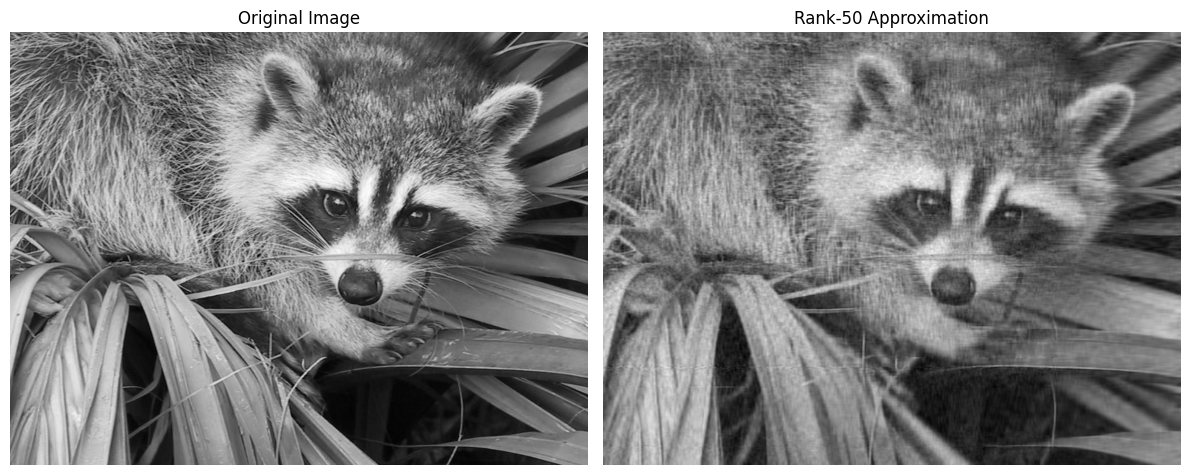

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.datasets  # Changed from scipy.misc.face to generic sample if available, or we generate one

try:
    img = scipy.datasets.face(gray=True)
except (AttributeError, ImportError):
    # Fallback: Create a gradient image if scipy is not available or old version
    x = np.linspace(0, 1, 512)
    y = np.linspace(0, 1, 512)
    X, Y = np.meshgrid(x, y)
    img = np.sin(10*X) * np.cos(10*Y)

def compress_svd(image, k):
    """
    Compress image using top-k singular values.
    """
    # 1. Decompose
    # U: (M, M), s: (min(M,N),), Vt: (N, N)
    U, s, Vt = np.linalg.svd(image, full_matrices=False)

    # 2. Keep only top k
    U_k = U[:, :k]
    s_k = np.diag(s[:k])
    Vt_k = Vt[:k, :]

    # 3. Reconstruct: A_k = U_k * S_k * Vt_k
    return np.dot(U_k, np.dot(s_k, Vt_k))

# -- Visualization --
k_val = 50
img_compressed = compress_svd(img, k_val)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Rank-{k_val} Approximation")
plt.imshow(img_compressed, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## 6. Conclusion

In this project, we peeked under the hood of linear algebra libraries.

1.  **Complexity:** Our `__matmul__` implementation was a naive $O(n^3)$. Modern libraries use Strassen's algorithm or tiling optimization to approach $O(n^{2.8})$ or better cache locality.
2.  **Precision:** Pure Python floats are double precision, but matrix decompositions are sensitive to numerical instability.
3.  **Scale:** SVD on a 1024x1024 image takes milliseconds with NumPy (C/LAPACK) but would take minutes or hours with a naive Python implementation.

Understanding these foundations is crucial for debugging model instabilities (vanishing gradients = small eigenvalues) and efficient architecture design.